Анализ работы сервиса "Автоподписка".
На сайте пользователь совершает целевые действия, 
(нажимает кнопки «Оставить заявку», «Заказать звонок»)
или нецелевые действия (просмотр карточек авто или 
просмотр основной страницы и страницы с помощью)
Необходимо решить задачу классификации -  предсказывать совершение целевого действия пользователем.
Данные для обработки представлен двумя файлами - ga_sessions.csv и ga_hits-002.csv
Целевые действия клиента (события типа "оставить заявку", "заказать звонок") находятся в ga_hits-002.csv.
Необходимо выделить целевые события
Провести разведочный анализ (sklearn) датасета ga_sessions.csv
Произвести типизацию данных
Добавить новые фичи для обработки
Произвести обработку категориальных и числовых признаков
На полученных данных провести обучение моделей RandomForestClassifier, LogisticRegression,  MLPClassifier
Выбрать лучшую модель на основе метрики ROC-AUC
Проверить работоспособность модели.

## Импортируем необходимые пакеты

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FormatStrFormatter
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import missingno as msno

In [2]:
df_1 = pd.read_csv('ga_sessions.csv', low_memory=False)
df_1.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [3]:
print(f'Размер выбоpки: {df_1.shape[0]}, {df_1.shape[1]}')

Размер выбоpки: 1860042, 18


In [4]:
df_2 = pd.read_csv('ga_hits-002.csv', low_memory=False)
df_2.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [5]:
print(f'Размер выбоpки: {df_2.shape[0]}, {df_2.shape[1]}')

Размер выбоpки: 15726470, 11


In [6]:
# в 'target' выделяем целевые события
df_2['target'] = df_2['event_action'].isin(['sub_car_claim_click', 
                                        'sub_car_claim_submit_click', 
                                        'sub_open_dialog_click', 
                                        'sub_custom_question_submit_click', 
                                        'sub_call_number_click', 
                                        'sub_callback_submit_click', 
                                        'sub_submit_success', 
                                        'sub_car_request_submit_click'])


df_2.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value,target
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN,False
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN,False
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN,False
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN,False
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN,False


In [7]:
df_new = df_2.copy()

In [8]:
# логические True и False переводим в 1 и 0
df_new['target'] = df_new['target'].astype(int)

In [ ]:
# %%time
# группируем...
# df_fin = df_fin.groupby(['session_id', 'target'], as_index=False).max()

In [9]:
# удаляем ненужные колонки
columns_for_drop = ['hit_date', 
                    'hit_time', 
                    'hit_number', 
                    'hit_type', 
                    'hit_referer',
                    'hit_page_path', 
                    'event_category', 
                    'event_action', 
                    'event_label',
                    'event_value']
df_new = df_new.drop(columns_for_drop, axis=1)
print(f'Размер выбоpки: {df_new.shape[0]}, {df_new.shape[1]}')

Размер выбоpки: 15726470, 2


In [10]:
# обьединяем датафреймы 
df_fin = pd.merge(left=df_1, right=df_new, on='session_id', how='inner')
df_fin.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
2,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
3,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
4,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15685214,9055430416266113553.1640968742.1640968742,2108381692.1640968721,2021-12-31,19:39:02,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,oKjXDUsycmahkgMhGdAR,desktop,Linux,NaN,NaN,1366x768,Chrome,Russia,Moscow,0
15685215,9055430416266113553.1640968742.1640968742,2108381692.1640968721,2021-12-31,19:39:02,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,oKjXDUsycmahkgMhGdAR,desktop,Linux,NaN,NaN,1366x768,Chrome,Russia,Moscow,0
15685216,9055430416266113553.1640968742.1640968742,2108381692.1640968721,2021-12-31,19:39:02,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,oKjXDUsycmahkgMhGdAR,desktop,Linux,NaN,NaN,1366x768,Chrome,Russia,Moscow,0
15685217,9055430416266113553.1640968742.1640968742,2108381692.1640968721,2021-12-31,19:39:02,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,oKjXDUsycmahkgMhGdAR,desktop,Linux,NaN,NaN,1366x768,Chrome,Russia,Moscow,0


In [11]:
print(f'Размер выбоpки: {df_fin.shape[0]}, {df_fin.shape[1]}')

Размер выбоpки: 15685219, 19


In [40]:
%%time
df_fin = df_fin.groupby(['session_id', 'target'], as_index=False).max()

CPU times: total: 29min 47s
Wall time: 29min 50s


In [13]:
print(f'Размер выбоpки: {df_fin.shape[0]}, {df_fin.shape[1]}')

Размер выбоpки: 1781974, 19


In [14]:
# колличество целевых и не целевых событий
df_fin['target'].value_counts()

target
0    1731660
1      50314
Name: count, dtype: int64

In [15]:
# удаляем 'session_id'
df_fin = df_fin.drop(['session_id'], axis=1)
print(f'Размер выбоpки: {df_fin.shape[0]}, {df_fin.shape[1]}')

Размер выбоpки: 1781974, 18


In [17]:
# СОХРАНЕНИЕ ДАТАСЕТА В НОВЫЙ Ф-Л
df_fin.to_csv('sber_avto_final.csv', index=False)

## EDA (разведочный анализ)

In [44]:
# проверка дублирующихся значений в датасете
df_fin.duplicated().sum()

0

In [ ]:
# если есть, то удаляем дубликаты
# df_fin = df_fin.drop_duplicates()
# df_fin.duplicated().sum()

In [18]:
df_fin = pd.read_csv('sber_avto_final.csv', low_memory=False)

In [19]:
#количество полностью заполненных объектов и их процент из всей выборки
def object_info(df):
    print('Количество заполненных объектов:', 
          len(df.dropna()))
    print('Процент заполненных объектов:', 
          round(len(df.dropna()) / len(df) * 100, 2))

object_info(df_fin)

Количество заполненных объектов: 14118
Процент заполненных объектов: 0.79


In [20]:
# процент пропущенных значений для каждого признака
missing_values = ((df_fin.isna().sum() / len(df_fin)) * 100).sort_values(ascending=False)

print('Процент пропущенных значений:')
missing_values

Процент пропущенных значений:


device_model                99.135678
utm_keyword                 59.198282
device_os                   58.809163
device_brand                20.112695
utm_adcontent               17.550424
utm_campaign                11.356956
utm_source                   0.004546
client_id                    0.000000
geo_city                     0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
device_category              0.000000
visit_date                   0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
target                       0.000000
dtype: float64

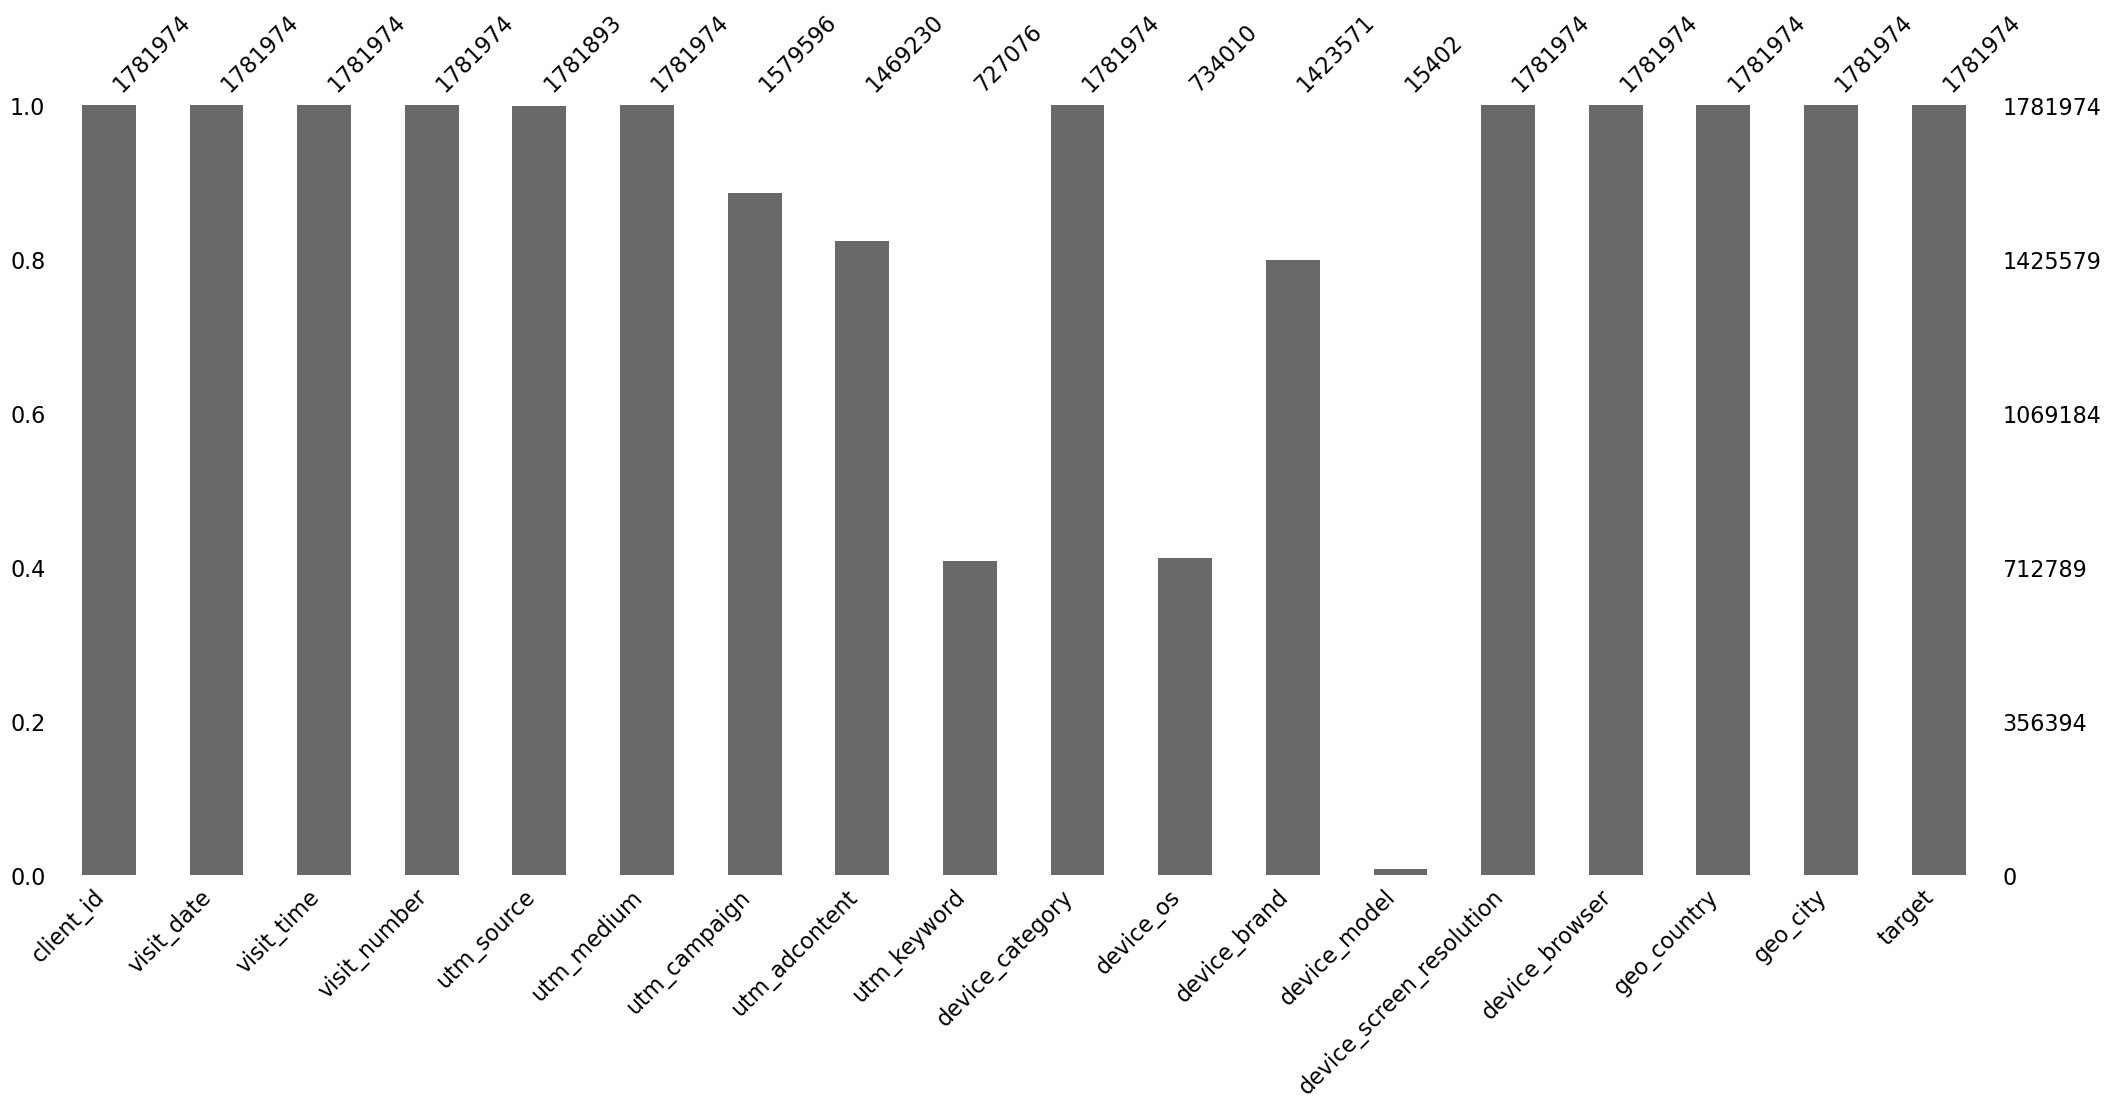

In [24]:
# bar  по заполняемости признаков
import missingno as msno
msno.bar(df_fin);

In [25]:
# удаляем ненужные колонки (неинформативные - пропущено от 20-30% значений) 
columns_for_drop = ['device_model', 
                    'utm_keyword', 
                    'device_os',
                    'device_brand'
                    ]


df_fin = df_fin.drop(columns_for_drop, axis=1)
print(f'Размер выбоpки: {df_fin.shape[0]}, {df_fin.shape[1]}')

Размер выбоpки: 1781974, 14


In [26]:
#создаем новый датафрейм
df_clean = df_fin.copy() 

In [27]:
# записи, в которых признак utm_adcontent не заполнен
df_clean['utm_adcontent'].value_counts(dropna=False)

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    968986
NaN                     312744
vCIpmpaGBnIQhyYNkXqp    183341
xhoenQgDQsgfEPYNPwKO    105628
PkybGvWbaqORmxjNunqZ     59997
                         ...  
PlanrlymnpCeYvUrUTVJ         1
JgmeMvxiYyrYlmqauiSv         1
EsbpyHMkFkavykEeYhch         1
QMmfrhgnqNOwSTPaqlLK         1
oJivRDNIrrOckRBIKOtG         1
Name: count, Length: 281, dtype: int64

In [28]:
# заполним пропущенные значением 'other'
df_clean['utm_adcontent'] = df_clean['utm_adcontent'].fillna('other') 

In [29]:
# записи, в которых признак utm_adcontent не заполнен
df_clean['utm_campaign'].value_counts(dropna=False)

utm_campaign
LTuZkdKfxRGVceoWkVyg    441701
LEoPHuyFvzoNfnzGgfcd    330612
FTjNLDyTrXaWYgZymFkV    237353
NaN                     202378
gecBYcKZCPMcVYdSSzKP    137788
                         ...  
qPDTdivQVeflLjTYIJnG         1
ZHCJROlbqnkXTqIuVxnm         1
RkpOyeEPgcMBSDuHLQcj         1
EsbMmeeLGwoYJmQRMBxd         1
cXxuwXPoQCvAXPHpFcZl         1
Name: count, Length: 407, dtype: int64

In [30]:
# заполним utm_campaign незаполненные значения самым популярным значением
# самое популярное значение передаем в виде моды
df_clean['utm_campaign'] = df_clean['utm_campaign'].fillna(df_clean['utm_campaign'].mode()[0])


In [31]:
#количество полностью заполненных объектов и их процент из всей выборки
def object_info(df):
    print('Количество заполненных объектов:', 
          len(df.dropna()))
    print('Процент заполненных объектов:', 
          round(len(df.dropna()) / len(df) * 100, 2))

object_info(df_clean)

Количество заполненных объектов: 1781893
Процент заполненных объектов: 100.0


## Data transormation

In [32]:
# выведем информацию о датафрейме с помощью info
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781974 entries, 0 to 1781973
Data columns (total 14 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   client_id                 float64
 1   visit_date                object 
 2   visit_time                object 
 3   visit_number              int64  
 4   utm_source                object 
 5   utm_medium                object 
 6   utm_campaign              object 
 7   utm_adcontent             object 
 8   device_category           object 
 9   device_screen_resolution  object 
 10  device_browser            object 
 11  geo_country               object 
 12  geo_city                  object 
 13  target                    int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 190.3+ MB


In [33]:
#скопируем датафрейм  df_clean в новый датафрейм df_types
df_types = df_clean.copy()

In [34]:
# меняем тип данных mask на int64
df_types['target'] = df_types['target'].astype(float)
df_types['target'] = df_types['target'].astype('int64')
df_types['target'].dtype

dtype('int64')

In [35]:
df_types['client_id'] = df_types['client_id'].astype(float)
df_types['client_id'] = df_types['client_id'].astype('int64')
df_types['client_id'].dtype

dtype('int64')

In [36]:
# приводим признак visit_date к типу данных datetime
df_types['visit_date'] = pd.to_datetime(df_types['visit_date'], utc=True)
df_types['visit_date'].dtype

datetime64[ns, UTC]

In [37]:
df_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781974 entries, 0 to 1781973
Data columns (total 14 columns):
 #   Column                    Dtype              
---  ------                    -----              
 0   client_id                 int64              
 1   visit_date                datetime64[ns, UTC]
 2   visit_time                object             
 3   visit_number              int64              
 4   utm_source                object             
 5   utm_medium                object             
 6   utm_campaign              object             
 7   utm_adcontent             object             
 8   device_category           object             
 9   device_screen_resolution  object             
 10  device_browser            object             
 11  geo_country               object             
 12  geo_city                  object             
 13  target                    int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(10)
memory usage: 190.

In [38]:
# Определяем  и удаляем выбросы
df_types['visit_number'].describe().apply(lambda x: f'{x:0.1f}')

count    1781974.0
mean           2.7
std           12.2
min            1.0
25%            1.0
50%            1.0
75%            2.0
max          564.0
Name: visit_number, dtype: object

In [39]:
# определяем границы нормальных значений
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries
boundaries = calculate_outliers(df_types['visit_number'])
boundaries

(-0.5, 3.5)

In [40]:
#Запишем в переменную is_outlier информацию о том, какие значения меньше нижней границы или больше верхней.
is_outlier = (df_types['visit_number'] < boundaries[0]) | (df_types['visit_number'] > boundaries[1])

In [41]:
#Выбросы у нас только среди максимальных значений, поэтому заменим их верхним граничным значением
df_types.loc[is_outlier, 'visit_number'] = int(boundaries[1])

In [42]:
df_types['visit_number'].describe().apply(lambda x: f'{x:0.1f}')

count    1781974.0
mean           1.4
std            0.7
min            1.0
25%            1.0
50%            1.0
75%            2.0
max            3.0
Name: visit_number, dtype: object

## визуализация категориальных переменных 

In [43]:
stats = df_types.groupby(['device_category'], as_index=False)[['client_id']].count()
stats = stats.rename(columns={'client_id': 'count'})
stats

,device_category,count
0,desktop,358093
1,mobile,1406765
2,tablet,17116


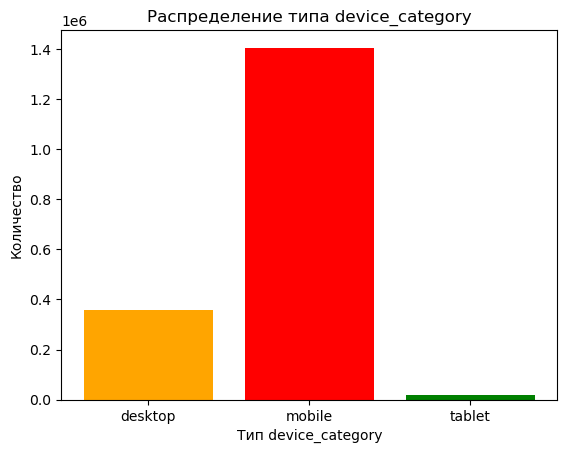

In [44]:
# Распределение сессий клиентов по типам устройств 
plt.bar(stats['device_category'], stats['count'], color=['orange', 'red', 'green'])
plt.xlabel('Тип device_category')
plt.ylabel('Количество')
plt.title('Распределение типа device_category');

In [ ]:
# СОХРАНЕНИЕ ДАТАСЕТА В НОВЫЙ Ф-Л
df_types.to_csv('sber_avto.csv', index=False)

## подготовка категориальных переменных

In [2]:
df_new1 = pd.read_csv('sber_avto.csv', low_memory=False)
df_new1.head()

,target,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_screen_resolution,device_browser,geo_country,geo_city
0,0,232832813,2021-09-26 00:00:00+00:00,16:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,412x869,Chrome,Russia,Gelendzhik
1,0,232833013,2021-10-23 00:00:00+00:00,21:24:03,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,360x640,Samsung Internet,Russia,Voronezh
2,0,232833760,2021-10-28 00:00:00+00:00,09:35:56,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,412x846,Chrome,Russia,Cherkessk
3,0,232834672,2021-06-12 00:00:00+00:00,12:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,360x780,Chrome,Russia,Irkutsk
4,0,232835435,2021-06-29 00:00:00+00:00,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,414x736,Safari,Russia,Moscow


In [3]:
print(f'Размер выбоpки: {df_new1.shape[0]}, {df_new1.shape[1]}')

Размер выбоpки: 1781974, 14


In [3]:
# Создаем датафрейм data, содержащий только выбранные категориальные переменные
# ТАКОЙ обьем не формируется:(, комп слабый , кусками делаю....
data = df_new1[['utm_medium', 'utm_campaign','device_category', 'device_browser']]

In [4]:
ohe = OneHotEncoder()
ohe

OneHotEncoder()

In [5]:
ohe_data = pd.DataFrame(ohe.fit_transform(data).toarray())

In [6]:
df_new1 = df_new1.join(ohe_data)
df_new1.head()

,target,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,...,509,510,511,512,513,514,515,516,517,518
0,0,232832813,2021-09-26 00:00:00+00:00,16:00:00,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,PkybGvWbaqORmxjNunqZ,mobile,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,232833013,2021-10-23 00:00:00+00:00,21:24:03,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,232833760,2021-10-28 00:00:00+00:00,09:35:56,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,232834672,2021-06-12 00:00:00+00:00,12:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,232835435,2021-06-29 00:00:00+00:00,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
print(f'Размер выбоpки: {df_new1.shape[0]}, {df_new1.shape[1]}')

Размер выбоpки: 1781974, 533


In [8]:
# удаляем неинформативные колонки, которые появились в датасете в результате Feature engineering
columns_for_drop = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_category', 
                    'device_browser']

In [9]:
df_new1 = df_new1.drop(columns_for_drop, axis=1)
#df_new1 = df_new1.drop('device_browser', axis=1)

In [10]:
print(f'Размер выбоpки: {df_new1.shape[0]}, {df_new1.shape[1]}')

Размер выбоpки: 1781974, 527


In [11]:
# СОХРАНЕНИЕ ДАТАСЕТА В НОВЫЙ Ф-Л
df_new1.to_csv('sber_avto_fin_OHE.csv', index=False)

##   стандартизация данных StandardScaler()
* создаем датафрейм data под колличественные переменные

In [16]:
#df_new = df_new1.copy()

In [2]:
df_new = pd.read_csv('sber_avto_fin_OHE.csv', low_memory=False)
df_new.head()

,target,client_id,visit_date,visit_time,visit_number,device_screen_resolution,geo_country,geo_city,0,1,...,509,510,511,512,513,514,515,516,517,518
0,0,232832813,2021-09-26 00:00:00+00:00,16:00:00,1,412x869,Russia,Gelendzhik,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,232833013,2021-10-23 00:00:00+00:00,21:24:03,1,360x640,Russia,Voronezh,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,232833760,2021-10-28 00:00:00+00:00,09:35:56,1,412x846,Russia,Cherkessk,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,232834672,2021-06-12 00:00:00+00:00,12:00:00,1,360x780,Russia,Irkutsk,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,232835435,2021-06-29 00:00:00+00:00,08:00:00,1,414x736,Russia,Moscow,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# новый признак по городам
df_new['city_new'] = df_new['geo_city'].isin(['Moscow', 
                                        'Saint Petersburg'])

In [4]:
# логические True и False переводим в 1 и 0
df_new['city_new'] = df_new['city_new'].astype(int)

In [5]:
df_new = df_new.drop(['geo_country', 'geo_city'], axis=1)
print(f'Размер выбоpки: {df_new.shape[0]}, {df_new.shape[1]}')

Размер выбоpки: 1781974, 526


In [6]:
# Преобразуем признак разрешение экрана (в площадь)
df_new['device_screen_width'] = df_new['device_screen_resolution'].str.split('x', n=1).str[0]
df_new['device_screen_height'] = df_new['device_screen_resolution'].str.split('x', n=1).str[1]
df_new['device_screen_width'] = df_new['device_screen_width'].astype(int)
df_new['device_screen_height'] = df_new['device_screen_height'].astype(int)
df_new['device_screen_area'] = df_new['device_screen_width'] * df_new['device_screen_height']

In [7]:
df_new = df_new.drop(['device_screen_width', 'device_screen_height','device_screen_resolution'], axis=1)
#df_new = df_new.drop(['device_screen_resolution'], axis=1)
print(f'Размер выбоpки: {df_new.shape[0]}, {df_new.shape[1]}')


Размер выбоpки: 1781974, 526


In [8]:
# создаем новый признак month, обозначающий номер месяца посещения сайта
df_new['visit_date'] = pd.to_datetime(df_new['visit_date'], utc=True)
df_new['month'] = df_new['visit_date'].apply(lambda x: x.month)
df_new['month']

0           9
1          10
2          10
3           6
4           6
           ..
1781969     7
1781970     7
1781971    12
1781972     6
1781973    10
Name: month, Length: 1781974, dtype: int32

In [9]:
# создаем новый признак dayofweek, обозначающий день недели посещения сайта
df_new['dayofweek'] = df_new['visit_date'].dt.dayofweek
df_new['dayofweek']

0          6
1          5
2          3
3          5
4          1
          ..
1781969    2
1781970    1
1781971    3
1781972    6
1781973    4
Name: dayofweek, Length: 1781974, dtype: int32

In [10]:
df_new.head()

,target,client_id,visit_date,visit_time,visit_number,0,1,2,3,4,...,513,514,515,516,517,518,city_new,device_screen_area,month,dayofweek
0,0,232832813,2021-09-26 00:00:00+00:00,16:00:00,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,358028,9,6
1,0,232833013,2021-10-23 00:00:00+00:00,21:24:03,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,230400,10,5
2,0,232833760,2021-10-28 00:00:00+00:00,09:35:56,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,348552,10,3
3,0,232834672,2021-06-12 00:00:00+00:00,12:00:00,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,280800,6,5
4,0,232835435,2021-06-29 00:00:00+00:00,08:00:00,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,304704,6,1


In [11]:
# удаляем колонки, которые появились в датасете в результате Feature engineering
columns_for_drop = ['visit_date', 'visit_time']

In [12]:
df_new = df_new.drop(columns_for_drop, axis=1)

In [13]:
df_new.head()

,target,client_id,visit_number,0,1,2,3,4,5,6,...,513,514,515,516,517,518,city_new,device_screen_area,month,dayofweek
0,0,232832813,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,358028,9,6
1,0,232833013,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,230400,10,5
2,0,232833760,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,348552,10,3
3,0,232834672,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,280800,6,5
4,0,232835435,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,304704,6,1


In [13]:
data_1 = ['visit_number', 'device_screen_area', 'month', 'dayofweek']
data = df_new[data_1]
data.head()

,visit_number,device_screen_area,month,dayofweek
0,1,358028,9,6
1,1,230400,10,5
2,1,348552,10,3
3,1,280800,6,5
4,1,304704,6,1


In [14]:
# Создаем объект std_scaler класса StandardScaler с параметрами по умолчанию
std_scaler = StandardScaler()
std_scaler

StandardScaler()

In [15]:
# Идентифицируем параметры преобразования на датафрейме с количественными переменными
#std_scaler.fit(data[['client_id', 'visit_number', 'city_new', 'device_screen_area']])
std_scaler.fit(data[['visit_number', 'device_screen_area', 'month', 'dayofweek']])

StandardScaler()

In [16]:
# Делаем преобразование для датафрейма и сохраняем в std_scaled, печатаем получившуюся матрицу
#std_scaled = std_scaler.transform(data[['client_id', 'visit_number', 'city_new', 'device_screen_area']])
std_scaled = std_scaler.transform(data[['visit_number', 'device_screen_area', 'month', 'dayofweek']])
std_scaled


array([[-0.54169197, -0.35731944, -0.11816367,  1.61570869],
       [-0.54169197, -0.53865072,  0.33314931,  1.11252232],
       [-0.54169197, -0.37078275,  0.33314931,  0.10614959],
       ...,
       [-0.54169197, -0.37854447,  1.23577526,  0.10614959],
       [-0.54169197, -0.43751394, -1.47210259,  1.61570869],
       [-0.54169197, -0.38967344,  0.33314931,  0.60933596]])

In [17]:
# Создаем наименования новых признаков по шаблону: visit_number_std для visit_number и т.д.
#df_new[['client_id_std','visit_number_std', 'city_new_std', 'device_screen_area_std']] = std_scaled
df_new[['visit_number', 'device_screen_area', 'month', 'dayofweek']] = std_scaled
df_new.head()

,target,client_id,visit_number,0,1,2,3,4,5,6,...,513,514,515,516,517,518,city_new,device_screen_area,month,dayofweek
0,0,232832813,-0.541692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.357319,-0.118164,1.615709
1,0,232833013,-0.541692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.538651,0.333149,1.112522
2,0,232833760,-0.541692,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.370783,0.333149,0.106150
3,0,232834672,-0.541692,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.467043,-1.472103,1.112522
4,0,232835435,-0.541692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.433081,-1.472103,-0.900223


In [18]:
print(f'Размер выбоpки: {df_new.shape[0]}, {df_new.shape[1]}')

Размер выбоpки: 1781974, 526


In [20]:
df_new = df_new.drop('client_id', axis=1)

In [21]:
print(f'Размер выбоpки: {df_new.shape[0]}, {df_new.shape[1]}')


Размер выбоpки: 1781974, 525


In [22]:
# СОХРАНЕНИЕ ДАТАСЕТА В НОВЫЙ Ф-Л
df_new.to_csv('sber_avto_fin.csv', index=False)


# Modeling

In [2]:
df_prepared = pd.read_csv('sber_avto_fin.csv')
print(f'Размер выбоpки: {df_prepared.shape[0]}, {df_prepared.shape[1]}')
df_prepared.head()

Размер выбоpки: 1781974, 525


,target,visit_number,0,1,2,3,4,5,6,7,...,513,514,515,516,517,518,city_new,device_screen_area,month,dayofweek
0,0,-0.541692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.357319,-0.118164,1.615709
1,0,-0.541692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.538651,0.333149,1.112522
2,0,-0.541692,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.370783,0.333149,0.106150
3,0,-0.541692,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.467043,-1.472103,1.112522
4,0,-0.541692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.433081,-1.472103,-0.900223


In [3]:
# целевые...
df_prepared['target'].value_counts()

target
0    1731660
1      50314
Name: count, dtype: int64

In [4]:
# Балансировка датасета
df1 = df_prepared[df_prepared['target'] == 1]
df0 = df_prepared[df_prepared['target'] == 0]
df0 = df0.iloc[:50314]
df_prepared1 = pd.concat([df1, df0], axis=0)
df_prepared1 = df_prepared1.sample(frac=1).reset_index(drop=True)

In [5]:
print(f'Размер выбоpки: {df_prepared1.shape[0]}, {df_prepared1.shape[1]}')

Размер выбоpки: 100628, 525


In [3]:
# делим данные на треин и тест и выделяем целевую переменную
x = df_prepared.drop(['target'], axis=1)
y = df_prepared['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train.shape, x_test.shape

((1247381, 524), (534593, 524))

## RandomForestClassifier

In [8]:
%%time
#Подготовка модели случайного леса
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)

# #делаем predicted и считаем точность для RandomForestClassifier
predicted_train_rf = rf_clf.predict(x_train)
predicted_test_rf = rf_clf.predict(x_test)


CPU times: total: 48.7 s
Wall time: 48.8 s


In [9]:
# тюнинг RandomForestClassifier
rf_tuned = RandomForestClassifier(max_features='log2', min_samples_leaf=1, n_estimators=400)

train_auc = roc_auc_score(y_train, rf_clf.predict_proba(x_train)[:, 1])
test_auc = roc_auc_score(y_test, rf_clf.predict_proba(x_test)[:, 1])

#print("ROC AUC точность модели training data:", train_auc)
print("ROC AUC точность модели test data:", test_auc)
            
confusion_matrix(y_test, predicted_test_rf) # матрица ошибок     
      

ROC AUC точность модели test data: 0.6587383494593289


array([[9365, 5652],
       [6051, 9121]], dtype=int64)

## LogisticRegression

In [10]:
# инициализируем LogisticRegression с дефолтными параметрами
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [11]:
%%time
# делаем predicted и считаем точность для LogisticRegression
pred_log_tr = logreg.predict(x_train)
pred_log_test = logreg.predict(x_test)

train_auc = roc_auc_score(y_train, logreg.predict_proba(x_train)[:, 1])
test_auc = roc_auc_score(y_test, logreg.predict_proba(x_test)[:, 1])

#print("ROC AUC точность модели training data:", train_auc)
print("ROC AUC точность модели test data:", test_auc)

confusion_matrix(y_test, pred_log_test) # матрица ошибок

ROC AUC точность модели test data: 0.6740133416068169
CPU times: total: 3.5 s
Wall time: 591 ms


array([[ 8630,  6387],
       [ 5104, 10068]], dtype=int64)

## MLPClassifier (нейронные сети)

In [12]:
%%time
# модель многослойного персептрона (max_iter — количество итераций обучения)
mlp = MLPClassifier(random_state=42) max_iter=500)


CPU times: total: 0 ns
Wall time: 0 ns


In [13]:
%%time
mlp.fit(x_train, y_train)
pred_train_mlp = mlp.predict(x_train)
pred_test_mlp = mlp.predict(x_test)

train_auc = roc_auc_score(y_train, mlp.predict_proba(x_train)[:, 1])
test_auc = roc_auc_score(y_test, mlp.predict_proba(x_test)[:, 1])

#print("ROC AUC точность модели training data:", train_auc)
print("ROC AUC точность модели test data:", test_auc)


ROC AUC точность модели test data: 0.6793139538964549
CPU times: total: 59min 10s
Wall time: 7min 33s


In [4]:
%%time
# делаем тюнинг модели MLPClassifier
mlp_tuned = MLPClassifier(max_iter=600, hidden_layer_sizes=(100,20), random_state=42, activation = 'tanh')

mlp_tuned.fit(x_train, y_train)

CPU times: total: 57min 51s
Wall time: 11min 44s


MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 20), max_iter=600,
              random_state=42)

In [5]:
pred_mlp = mlp_tuned.predict(x_test)

test_auc = roc_auc_score(y_test, mlp_tuned.predict_proba(x_test)[:, 1])
print("ROC AUC точность модели test data:", test_auc)
      

ROC AUC точность модели test data: 0.6851337101355114


## Кросс-валидация

In [26]:
%%time
# делим датасет на 5 фолдов
# проверяем метрики точности каждой модели, смотрим на среднее значение метрики и стандартное отклонение
for model in [rf_clf, logreg, mlp]:
  cv_score = cross_val_score(model, x, y, cv=5)
  print(model, ':', cv_score.mean(), cv_score.std())
models = [
    LogisticRegression(solver='liblinear'),
    RandomForestClassifier(),
    MLPClassifier(max_iter=600, hidden_layer_sizes=(100,20), random_state=42, activation = 'tanh')
]

for m in models:
    score = cross_val_score(m, X, y, cv=4, scoring='roc_auc')
    print(f'model: {type(m).__name__}, acc_mean: {score.mean():.4f}, acc_std: {score.std():.4f}')

*Лучшая модель - Многослойный персептрон*
* среднее значение метрики roc_auc - 0,68
* отклонение метрики небольшое (0,002...), т.е. она мало меняется при итерациях и модель не переобучается

## Сохранение модели

In [6]:
%%time
# обучаем лучшую модель mlp_tuned на всем датасете
mlp_tuned.fit(x, y)

CPU times: total: 1h 21min 30s
Wall time: 15min 26s


MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 20), max_iter=600,
              random_state=42)

In [8]:
# Финализируем работу(стирилизуем). Сохраняем в файл sber_fin.pickle
filename = 'sber_fin_1.pickle'

with open(filename, 'wb') as file:
  pickle.dump(mlp_tuned, file)

## Проверка сохраненной модели

In [2]:
# Проверяем сохраненный ф-л, читаем...
#with open(filename, 'rb') as file:
with open('sber_fin_1.pickle', 'rb') as file:    
 fin_model = pickle.load(file)

In [3]:
# Смотрим, какая модель в ф-ле
fin_model

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 20), max_iter=600,
              random_state=42)

In [4]:
%%time
# С помощью нашей модели делаем предсказание на одной строке датасета
df = pd.read_csv('sber_avto_fin.csv')

CPU times: total: 2min 21s
Wall time: 2min 24s


In [5]:
# Берем рандомную строку исходного датасета
row = df.sample(1)
row_x = row.drop(['target'], axis=1)
row_y = row['target']


In [6]:
#%%time
# вызываем predict нашей модели
fin_model.predict(row_x)

array([0], dtype=int64)

In [7]:
# Сравним с реальным значением этой строки
row_y

1664773    0
Name: target, dtype: int64

# * МОДЕЛЬ РАБОТАЕТ И ПРЕДСКАЗАЛА ЗНАЧЕНИЕ ВЕРНО !

### В итоге мы видим, что лучший результат в данном случае показала модель MLPClassifier (однако при различных параметрах тюнинга LogisticRegression иногда мог показывать более высокие результаты).
### Попробовал обучать модели отдельно ТОЛЬКО на категориальных и отдельно на числовых фичах(после OneHotEncoder и StandardScaler соответсвенно). На категориальных были более высокие результаты. Полагаю из-зы итогового колличества фичей. 
### Генерация дополнительных числовых фичей дает незначительный прирост ROC AUC (0,0001-0,0002) за каждй новый признак, но если совсем без них, то совсем плохо. 
### В этом коде есть блок - # новые признаки из категориальных в числовые device_category - mobil => is_mobile ... предположительно может дать прирост ROC AUC 0,0003 (из категориальных device_category надо будет убирать). 
### Все эти результаты бали показаны на сбалансированном датасете (несбалансированный был сильно дольше 4ч.+ и показатели метрики ROC AUC меньше 0,66+-).  


